# Inference Notebook for XRD Structure Factor Reconstruction

This notebook demonstrates the inference process using a trained FFT-UNet (in our case, but could be changed by user) model for reconstructing high-resolution X-ray diffraction (XRD) patterns from low-resolution data.

The notebook:
1. Loads a trained FFT-UNet model from saved weights
2. Processes test data from a toy CSD dataset
3. Creates intensity tensors and normalizes the data
4. Performs reconstruction using the model
5. Saves the reconstructed data to a file
6. Uses SHELX to refine the reconstructed data



In [401]:
from models.unet_fft import UNet_FFT
from models.model import MiniUnet
from models.xrd_transformer import XRDTransformer
import numpy as np
import torch
import torch.nn as nn
from utils.functions import (
    R_factor,
    get_state_dict,
    make_dicts,
    create_intensity_tensors
)

weights_path = 'weights/FFT_UNet/synth+csd/model.ckpt'
model = UNet_FFT(2)
state_dict = get_state_dict(weights_path)
model.eval()
model.load_state_dict(state_dict, strict=True)

Dictionary loaded successfully


<All keys matched successfully>

You could use your own types of XRD data, but please make sure to adjust the code accordingly, so Intensity, Ind_high, and Ind_low are correctly defined.

In [402]:
test_data = np.load(
    'xrd_datasets/toy_csd/data/test_498.npz',
    allow_pickle=True
)
intensity = test_data['Intensity']
ind_high = test_data['Ind_high']
ind_low = test_data['Ind_low']
print(intensity.shape, ind_high.shape, ind_low.shape)

(2916,) (2916, 3) (467, 3)


### Putting our data into the correct 3D tensors for the model

In [403]:
h2ind, k2ind, l2ind, ind2h, ind2k, ind2l = make_dicts('clin')
low, high = create_intensity_tensors(
    intensity,
    ind_high,
    ind_low,
    'clin',
    h2ind,
    k2ind,
    l2ind
)

0 / 2916 didnt fit into high tensor
0 / 467 didnt fit into low tensor
Shapes are (1, 1, 26, 18, 23) and (1, 1, 26, 18, 23) for low and high respectively


### Data preprocessing:
1. Convert intensities to structure factor amplitudes by taking square root
2. Normalize the amplitudes by dividing by the maximum value of low resolution data

 Note: Modify this preprocessing if using different data types or requirements

In [404]:
high = torch.sqrt(high)
low = torch.sqrt(low)
factor = low.max()
low = low / factor
high = high / factor
print(f'Factor is {factor:.3f}')

Factor is 249.999


In [405]:
recon = nn.ReLU()(model(low)).detach()
mask = low == 0
recon = recon * mask + ~mask * low
print(f'R factor is {R_factor(recon, high):.3f}')

R factor is 0.282


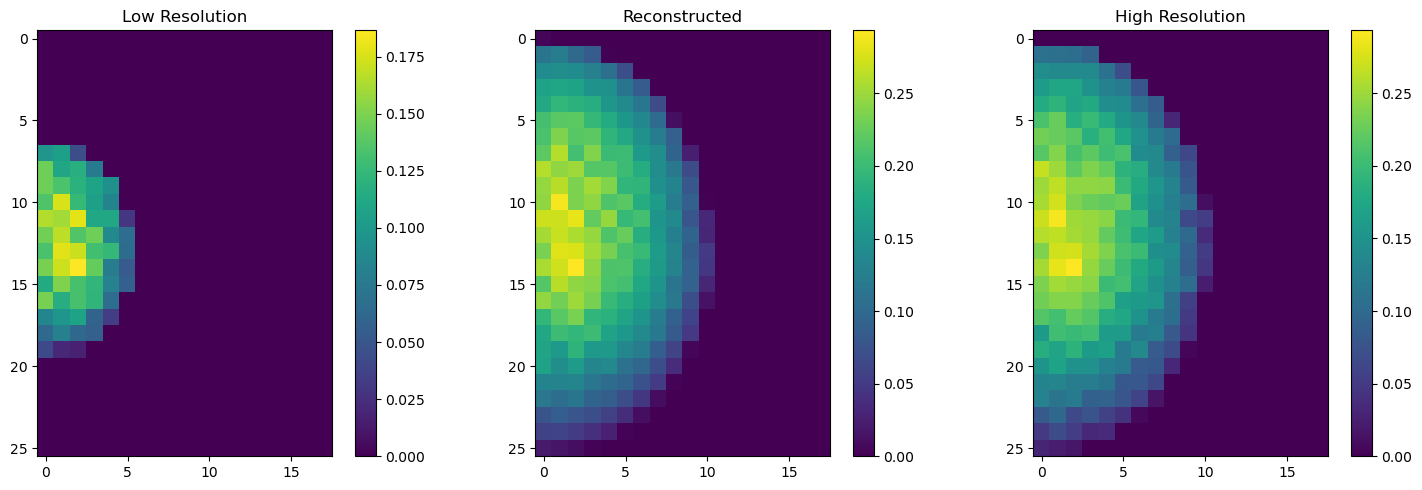

In [406]:
import matplotlib.pyplot as plt

# Create a figure with 3 subplots side by side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Sum along l axis to get 2D projections
low_proj = low[0, 0].mean(dim=-1).numpy()
recon_proj = recon[0, 0].mean(dim=-1).numpy()
high_proj = high[0, 0].mean(dim=-1).numpy()

# Plot each projection
im1 = ax1.imshow(low_proj, cmap='viridis')
ax1.set_title('Low Resolution')
plt.colorbar(im1, ax=ax1)

im2 = ax2.imshow(recon_proj, cmap='viridis')
ax2.set_title('Reconstructed')
plt.colorbar(im2, ax=ax2)

im3 = ax3.imshow(high_proj, cmap='viridis')
ax3.set_title('High Resolution')
plt.colorbar(im3, ax=ax3)

plt.tight_layout()
plt.show()


## Next Steps:
1. Convert reconstructed data to .hkl file format (code provided below)
2. Create a .ins file with structure refinement parameters
3. Run SHELX for structure refinement

### The code in the following cells handles the .hkl file conversion.
### You'll need to create an appropriate .ins file based on your structure.

In [407]:
# Convert ind_low to list of tuples
ind_low = [tuple(ind) for ind in ind_low]
intensity = np.sqrt(intensity)
assert np.allclose(intensity.max(), factor)

# Scale reconstruction and extract first batch/channel
recon *= factor
recon = recon.numpy()[0, 0]
assert recon.max() == factor

# Initialize lists to store reconstructed indices and intensities
recon_ind = []
recon_ampl = []

# Iterate through reconstruction volume
for h in range(recon.shape[0]):
    for k in range(recon.shape[1]):
        for l in range(recon.shape[2]):
            current_ind = (ind2h[h], ind2k[k], ind2l[l])
            if current_ind not in ind_low:
                amplitude_current = round(float(recon[h, k, l]), 2)
                if amplitude_current != 0:
                    recon_ind.append(current_ind)
                    recon_ampl.append(amplitude_current)

# Add missing low resolution indices
for ind in ind_low:
    exists = any(
            all(x == y for x, y in zip(ind, existing_ind))
            for existing_ind in recon_ind
    )
    if not exists:
        j = np.where((ind_high == ind).all(axis=1))[0][0]
        recon_ind.append(tuple(ind))
        recon_ampl.append(round(float(intensity[j]), 2))

In [408]:
import os

os.makedirs('tmp', exist_ok=True)

# Format intensities with proper padding
def pad_intensity(x):
    value = str(x**2) + '0' if str(x**2)[-2] == '.' else str(x)
    return ' ' * (8 - len(value)) + value

recon_ampl = [pad_intensity(x) for x in recon_ampl]

# Extract and pad h,k,l indices
hh, kk, ll = [], [], []
for h, k, l in recon_ind:
    hh.append(str(h))
    kk.append(str(k)) 
    ll.append(str(l))

def pad_index(x):
    return ' ' * (3 - len(x)) + x

hh = [pad_index(x) for x in hh]
kk = [pad_index(x) for x in kk]
ll = [pad_index(x) for x in ll]

# Build formatted strings
strings = []
for i in range(len(hh)):
    line = f" {hh[i]} {kk[i]} {ll[i]}{recon_ampl[i]}    0.01"
    strings.append(line)

# Write to file
with open('tmp/synt_recon.hkl', 'w') as f:
    for line in strings:
        f.write(f"{line}\n")

In [409]:
!shelxt tmp/synt_recon


 ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
 +  SHELXT  -  CRYSTAL STRUCTURE SOLUTION - VERSION 2018/2            +
 +  Copyright(c)  George M. Sheldrick 2010-2018  All Rights Reserved  +
 +  Started at 02:33:03 on 19 Nov 2024                                +
 ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

 ** Cannot open file tmp/synt_recon.ins **


